In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from stable_baselines3 import DQN
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.monitor import Monitor
import torch.nn as nn


In [2]:
# Callback per registrare le metriche
class CustomCallback(BaseCallback):
    def __init__(self, max_episodes, verbose=0):
        super(CustomCallback, self).__init__(verbose)
        self.max_episodes = max_episodes
        self.rewards = []
        self.episode_counter = 0
        self.losses = []
        self.step_counter = 0
        self.info = []
        self.epsilon_per_episode = []
        self.epsilon_per_step = []
        self.training = False
        self.step_before_training_counter = 0
        self.max_eps = 1.0
        self.min_eps = 0.1
        self.current_eps = self.max_eps
        
    def _on_step(self):        
        # Controllo che sia iniziato il training
        if not self.training:
            if self.step_before_training_counter == self.model.learning_starts:
                self.training =  True
                
            else:
                self.step_before_training_counter += 1

        # Training iniziato
        else:
            done = self.locals['dones']
            self.epsilon_per_step.append(self.model.exploration_rate)
            # Azioni da eseguire alla fine dell'episodio
            if done[0]:
                # Imposta il nuovo valore di epsilon nel modello
                # self.current_eps = max(self.min_eps, self.max_eps * (1 - self.episode_counter/self.max_episodes))
                # self.model.exploration_rate = self.current_eps
                
                reward = self.locals['infos'][0]['episode']['r']
                self.rewards.append(reward)
                self.info.append(self.locals['infos'])
                self.epsilon_per_episode.append(self.model.exploration_rate)
                self.episode_counter += 1

                if self.episode_counter % 100 == 0 and self.episode_counter != 0:
                    ma_reward = np.mean(np.array(self.rewards[-100:]))
                    
                    ma_loss = np.mean(np.array(self.losses[-100:]))
                    epsilon = self.model.exploration_rate
                    print(f"Ep {self.episode_counter}/{self.max_episodes}, MA Reward: {ma_reward:.2f}, MA loss: {ma_loss:.4f}, Eps: {epsilon:.2f}")
                    
            # Registra la loss ad ogni step dopo il training
            if 'train/loss' in self.model.logger.name_to_value:
                self.losses.append(self.model.logger.name_to_value['train/loss'])

            self.step_counter += 1
            # Stampa il totale del reward per questo episodio
        

        
        if self.episode_counter == self.max_episodes:
            print('MAX EPISODES REACHED')
            return False
        return True


In [5]:
# Crea l'ambiente CartPole con il wrapper Monitor
env = Monitor(gym.make('CartPole-v1'))

# Configura il modello DQN con i parametri consigliati
# model = DQN(
#     'MlpPolicy',
#     env,
#     learning_rate=0.002,
#     buffer_size=100000,
#     learning_starts=1000,
#     batch_size=128,
#     tau = 0.001,
#     gamma=0.99,
#     train_freq=1,
#     gradient_steps=-1,
#     target_update_interval=1,
#     max_grad_norm=100,
#     policy_kwargs=dict(activation_fn=nn.ReLU, net_arch=[64]),
#     # policy_kwargs=dict(net_arch=[64]),
#     verbose=0
# )


model = DQN(
    'MlpPolicy',
    env,
    learning_rate=0.0023,
    buffer_size=100000,
    learning_starts=1000,
    batch_size=64,
    gamma=0.99,
    train_freq=256,
    gradient_steps=128,
    target_update_interval=10,
    policy_kwargs=dict(net_arch=[256, 256]),
    exploration_final_eps = 0.04,
    exploration_fraction = 0.16,
    verbose=0
)
# Crea il callback personalizzato per registrare le metriche
callback = CustomCallback(max_episodes=3000)

# Addestra l'agente
model.learn(total_timesteps=50000, callback=callback)

rewards = np.array(callback.rewards)
loss_history = np.array(callback.losses)

Ep 100/3000, MA Reward: 32.07, MA loss: 0.1029, Eps: 0.50
Ep 200/3000, MA Reward: 102.89, MA loss: 0.2227, Eps: 0.04
Ep 300/3000, MA Reward: 138.52, MA loss: 0.2306, Eps: 0.04
Ep 400/3000, MA Reward: 169.94, MA loss: 0.4917, Eps: 0.04
Ep 500/3000, MA Reward: 14.72, MA loss: 1.1779, Eps: 0.04


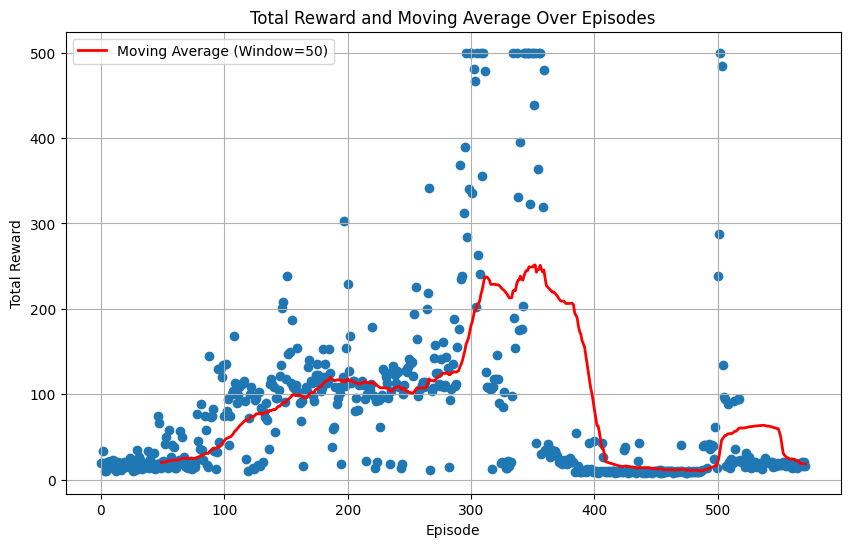

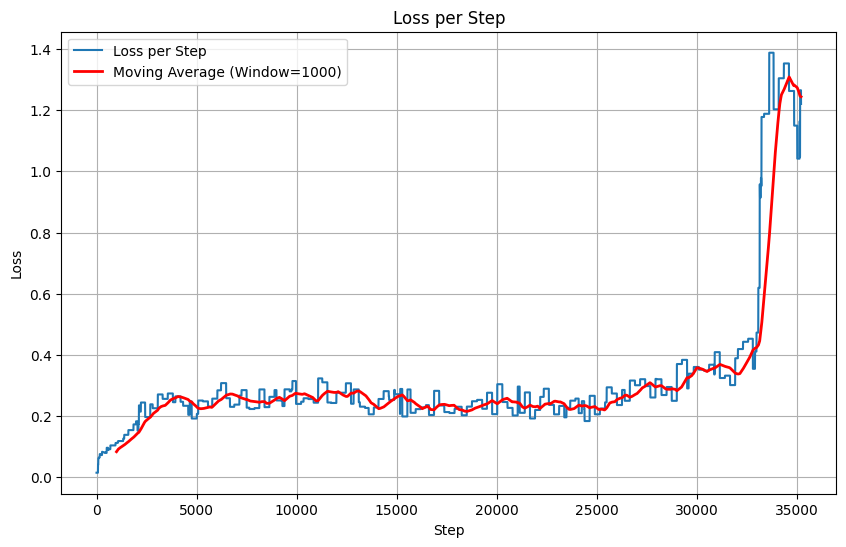

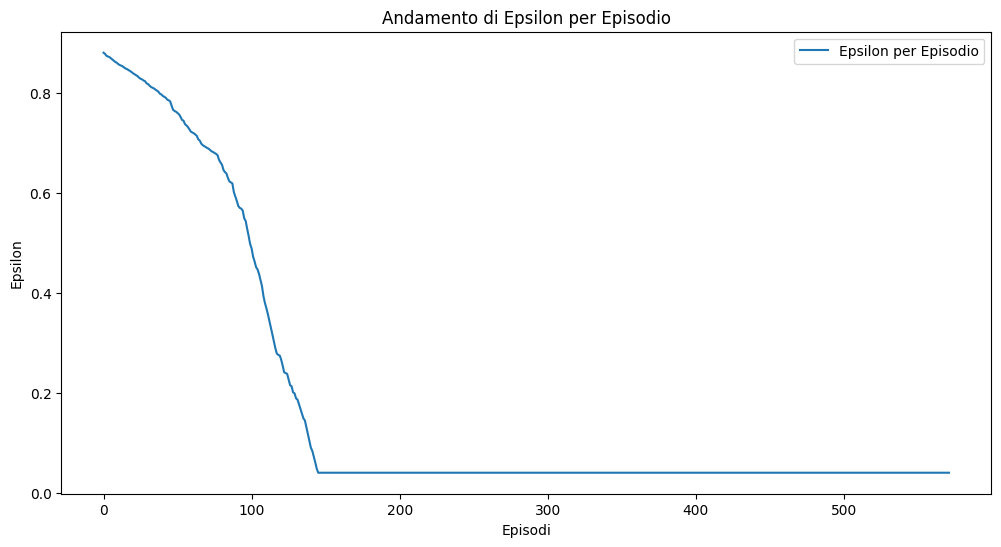

In [6]:
# Grafico 1: Reward per episodio e media mobile
window_size = 50
ma_reward = np.convolve(rewards, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.scatter(np.arange(len(rewards)), rewards)
plt.plot(np.arange(window_size - 1, len(rewards)), ma_reward, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)

plt.title('Total Reward and Moving Average Over Episodes')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid(True)
plt.show()

# Grafico 2: Andamento della loss per step e media mobile degli ultimi 1000 step
window_size = 1000
ma_loss = np.convolve(loss_history, np.ones(window_size) / window_size, mode='valid')
plt.figure(figsize=(10, 6))
plt.plot(np.arange(len(loss_history)), loss_history, label='Loss per Step')
plt.plot(np.arange(window_size - 1, len(loss_history)), ma_loss, color='red', label=f'Moving Average (Window={window_size})', linewidth=2)
plt.title('Loss per Step')
plt.xlabel('Step')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


# Grafico 3: Andamento di epsilon per episodio
plt.figure(figsize=(12, 6))
plt.plot(callback.epsilon_per_episode, label='Epsilon per Episodio')
plt.xlabel('Episodi')
plt.ylabel('Epsilon')
plt.title('Andamento di Epsilon per Episodio')
plt.legend()
plt.show()

In [ ]:
model.num_timesteps

In [ ]:
callback.episode_counter